# Deep Learning Course

## Assignment 2

### Assignment Goals

* Design and implementation of CNNs.
* CNN visualization.
* Implementation of ResNet.

In this assignment, you will be asked to learn CNN models for an image dataset. Different experiments will help you achieve a better understanding of CNNs.

### Dataset

The dataset consists of around 9K images (some grayscale and some RGB) belonging to 101 classes. The shape of each image is (64,64,3). Every image is labeled with one of the classes. The image file is contained in the folder named after the class name.


### Requirements

1. **(40 points) Implement and improve a CNN model.**

   (a) We are aiming to learn a CNN on the given dataset. Download the dataset, and use PyTorch to implement LeNet5 to classify instances. Use a one-hot encoding for labels. Split the dataset into training (90 percent) and validation (10 percent) and report the model loss (cross-entropy) and accuracy on both training and validation sets. (20 points)
   
    The LeNet5 configuration is:
      - Convolutional layer (kernel size 5 x 5, 32 filters, stride 1 x 1 and followed by ReLU)
      - Max Pooling layer with size 4 and stride 4 x 4
      - Convolutional layer (kernel size 5 x 5, 64 filters, stride 1 x 1 and followed by ReLU)
      - Max Pooling layer with size 4 and stride 4 x 4
      - Fully Connected ReLU layer that has 1021 neurons
      - Fully Connected ReLU layer with 84 neurons
      - Fully Connected Softmax layer that has input 84 and output which is equal to the number of classes (one node for each of the classes).

   (b) Try to improve model accuracy on the validation dataset by tuning the model hyperparameters. You can use any improvement methods you prefer. You are expected to reach at least 65 percent accuracy on validation set. (20 points)
    
    Here are some improvement methods you can use, of course you can use others which are not mentioned here:
    - Dropout
    - L1, L2 regularization
    - Try improved initialization (e.g., Xavier initialier)
    - Batch Normalization
    
   The grading of part (b) is based on the correctness of your implementation (5 points) and the performance of your improvement on the validation set. The validation accuracy and corresponding score is:
    - 65% (5 points)
    - 67% (8 points)
    - 69% (12 points)
    - 71% (15 points)


   **Structure of LENET-5**
   
   This following LENET-5 structure is for 10-class dataset. Therefore, the layer size is not exactly the same as ours.
   
   ![hw2_lenet5.png](hw2_lenet5.png)

2. **(20 points) Visualize layer activation**

    There are several approaches to understand and visualize convolutional Networks, including visualizing the activations and layers weights. The most straight-forward visualization technique is to show the activations of the network during the forward pass. The second most common strategy is to visualize the weights. For more information we recommend the course notes on ["Visualizing what ConvNets learn"](http://cs231n.github.io/understanding-cnn/). More advanced techniques can be found in "Visualizing and Understanding Convolutional Networks" paper by Matthew D.Zeiler and Rob Fergus.
    
    Please visualize the layer activation of **the first conv layer** and **the second conv layer** of your above CNN model (after completing Q1), on the following 2 images:
    - accordion/image_0001
    - camera/image_0001
    
   Visualizing a CNN layer activation means to visualize the result of the activation layer as an image. Specifically, the activation of the first conv layer is the output of the first (conv + ReLU) layer during forward propagation. Since we have 32 filters in the first conv layer, you should draw 32 activation images for the first conv layer. Please display multiple images side by side in a row to make your output more readable (Hint: matplotlib.pyplot.subplot).
    
    

3. **(40 points) ResNet Implementation**

    Use PyTorch to implement ResNet 18 to classify the given dataset. Same as above, please use a one-hot encoding for labels, split the dataset into training (90 percent) and validation (10 percent) and report the model loss (cross-entropy) and accuracy on both training and validation sets. See the paper [Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385) for detailed introduction of ResNet.
    
    The grading of this part is mainly based on the implementation and performance on validation set. If you need more resources to complete the training, consider using Google Colab.
    
    The ResNet 18 configuration is:
    -  conv_1 (kernel size 7 x 7, 64 filters, stride 2 x 2)
    -  conv_2 (max pooling layer with size 3 x 3, followed by 2 blocks.Each block contains two conv layers. Each conv layer has kernel size 3 x 3, 64 filters, stride 2 x 2)
    -  conv_3 (2 blocks, each contains 2 conv layers with kernel size 3*3, 128 filters)
    -  conv_4 (2 blocks, each contains 2 conv layers with kernel size 3*3, 256 filters)
    -  conv_5 (2 blocks, each contains 2 conv layers with kernel size 3*3, 512 filters)
    
   A block has the structure:
   
    ![hw2_resnet.png](hw2_resnet.png)
    <!--<img src="attachment:image.png" alt="drawing" width="400"/>-->

### Submission Notes

Please use Jupyter Notebook. The notebook should include the final code, results and your answers. You should submit your Notebook in (.pdf or .html) and .ipynb format. (penalty 10 points)

## Your Implementation

In [3]:
# You can use the following helper functions

from typing import Any
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import os
from torchvision.io import read_image
from torchvision import transforms
from sklearn.preprocessing import OneHotEncoder
import numpy as np
import torch
from torch import nn
from tqdm import tqdm
from matplotlib import pyplot as plt

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
#no transformer
class ImageDataset( Dataset ):

    def __init__(self, is_val= False, transform = None) -> None:


        if is_val:
            self.df = pd.read_csv( 'validation.csv', index_col=0 )
        else:
            self.df = pd.read_csv( 'train.csv', index_col= 0 )

        self.cls_names = self.df['cls_name'].unique().tolist()
        self.df['label'] = self.df['cls_name'].apply( self.cls_names.index )

        self.transform = transform


    def get_num_classes(self):
        return len( self.cls_names )

    def __len__(self):
        return len( self.df )

    def __getitem__(self, index):
        path = self.df.iloc[index]['path']
        img = read_image( path ).type( torch.float32 )

        target = self.df.iloc[index]['label']

        if self.transform is not None:
            img = self.transform( img )

        target = torch.tensor( target )

        return img/255 , target

# def collate_fn( batch ):
#     imgs, targets = [], []

#     for img, target in batch:
#         imgs.append( img )
#         targets.append( target )

#     imgs = torch.stack( imgs, dim= 0 )
#     targets = torch.stack( targets, dim= 0 )
#     return imgs, targets
def collate_fn(batch):
    imgs, targets = [], []
    for img, target in batch:
        # Convert img and target to tensors if they're not already.
        img = torch.tensor(img) if not isinstance(img, torch.Tensor) else img
        target = torch.tensor(target) if not isinstance(target, torch.Tensor) else target
        imgs.append(img)
        targets.append(target)

    imgs = torch.stack(imgs, dim=0)
    targets = torch.stack(targets, dim=0)
    return imgs, targets

In [6]:
#transformer
import pandas as pd
import torch
from torchvision.io import read_image
from torch.utils.data import Dataset
from PIL import Image

class ImageDataset_t(Dataset):
    def __init__(self, is_val=False, transform=None):
        super(ImageDataset_t, self).__init__()
        if is_val:
            self.df = pd.read_csv('validation.csv', index_col=0)
        else:
            self.df = pd.read_csv('train.csv', index_col=0)

        self.cls_names = self.df['cls_name'].unique().tolist()
        self.df['label'] = self.df['cls_name'].apply(self.cls_names.index)
        self.transform = transform

    def get_num_classes(self):
        return len(self.cls_names)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        path = self.df.iloc[index]['path']
        # Load image as PIL Image
        img = Image.open(path).convert('RGB')

        target = self.df.iloc[index]['label']

        if self.transform is not None:
            img = self.transform(img)

        target = torch.tensor(target, dtype=torch.long)  # here

        return img, target

def collate_fn(batch):
    imgs, targets = [], []
    for img, target in batch:
        imgs.append(img)
        targets.append(target)

    imgs = torch.stack(imgs, dim=0)
    targets = torch.stack(targets, dim=0)
    return imgs, targets



In [7]:
from torchvision import transforms, datasets
from torch.utils.data import DataLoader,random_split


# Assuming ImageDataset is a custom dataset class you've defined
# that properly handles the is_val flag and applies transformations.

# transform = {
#     'train': transforms.Compose([
#         # transforms.RandomResizedCrop(64),
#         # transforms.RandomHorizontalFlip(),
#         # transforms.ToTensor(),
#         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
#     ]),
# }
# total_size_train = len(ImageDataset(is_val=False))
# split_size_train = int(0.2 * total_size_train)  # 20% of the total size
# train_size_train = total_size_train - split_size_train  # The remaining 80%


# total_size_val = len(ImageDataset(is_val=True))
# split_size_val = int(0.2 * total_size_val)  # 20% of the total size
# train_size_val = total_size_val - split_size_val  # The remaining 80%


# Split the dataset
# train_dataset = random_split(ImageDataset(is_val=False), [train_size_train, split_size_train])
# val_dataset = random_split(ImageDataset(is_val=True), [train_size_val, split_size_val])

# train_transforms = transforms.Compose([
#     transforms.RandomResizedCrop(224),  # Example size, adjust to your needs
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomRotation(20),
#     transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
#     transforms.ToTensor(),  # Converts PIL Image or numpy.ndarray (H x W x C) in the range [0, 255] to torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0]
# ])

# val_transforms = transforms.Compose([
#     transforms.Resize(256),
#     transforms.CenterCrop(224),
#     transforms.ToTensor(),
# ])










train_dataset = ImageDataset(is_val=False )
val_dataset = ImageDataset(is_val=True)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)  # No need to shuffle validation data
print(type(train_dataloader))

<class 'torch.utils.data.dataloader.DataLoader'>


In [9]:

def init_weights( m ):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)


In [10]:
df = pd.read_csv( 'train.csv', index_col= 0 )
df.head()

,file_name,cls_name,path
0,image_0019.jpg,cougar_body,Dataset/train/cougar_body/image_0019.jpg
1,image_0001.jpg,cougar_body,Dataset/train/cougar_body/image_0001.jpg
2,image_0002.jpg,cougar_body,Dataset/train/cougar_body/image_0002.jpg
3,image_0003.jpg,cougar_body,Dataset/train/cougar_body/image_0003.jpg
4,image_0004.jpg,cougar_body,Dataset/train/cougar_body/image_0004.jpg


###  Implement and improve a CNN model

In [11]:
# implement your Lenet5 here
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms

In [12]:
# class LeNet5(nn.Module):
#     def __init__(self, num_classes=101):
#         super(LeNet5, self).__init__()
#         self.features = nn.Sequential(
#             nn.Conv2d(3, 32, kernel_size=5, stride=1),
#             nn.ReLU(inplace=True),
#             nn.BatchNorm2d(32),
#             nn.MaxPool2d(kernel_size=4, stride=4),
#             nn.Conv2d(32, 64, kernel_size=5, stride=1),
#             nn.ReLU(inplace=True),
#             nn.BatchNorm2d(64),
#             nn.MaxPool2d(kernel_size=4, stride=4),
#         )
#         self.classifier = nn.Sequential(
#             nn.Linear(256, 1021),  # Adjusted for the actual output size
#             nn.ReLU(inplace=True),
#             nn.BatchNorm1d(1021),
#             nn.Dropout(p=0.5),
#             nn.Linear(1021, 84),
#             nn.ReLU(inplace=True),
#             nn.BatchNorm1d(84),
#             nn.Dropout(p=0.5),
#             nn.Linear(84, num_classes),
#             nn.Softmax(dim=1)
#         )

#     def forward(self, x):
#         x = self.features(x)
#         x = torch.flatten(x, 1)
#         x = self.classifier(x)
#       #  print(x.size())
#         return x

# def init_weights(m):
#     if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
#         nn.init.xavier_uniform_(m.weight)
#         if m.bias is not None:
#             nn.init.constant_(m.bias, 0)


In [13]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torch.optim.lr_scheduler import StepLR


# # Model, loss function, optimizer, and scheduler setup
# num_epochs = 500
# batch_size = 64
# learning_rate = 0.001
# weight_decay = 0.00005

# model = LeNet5(num_classes=101).apply(init_weights)  # Apply Xavier initialization here
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
# scheduler = StepLR(optimizer, step_size=30, gamma=0.1)

# # Training and validation loops
# for epoch in range(num_epochs):
#     model.train()
#     running_loss = 0.0
#     correct = 0
#     total = 0
#     for images, labels in train_dataloader:  # Assume train_dataloader is defined elsewhere
#         optimizer.zero_grad()
#         outputs = model(images)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()
#         running_loss += loss.item()
#         _, predicted = torch.max(outputs.data, 1)
#         total += labels.size(0)
#         correct += (predicted == labels).sum().item()

#     train_loss = running_loss / len(train_dataloader)
#     train_accuracy = 100 * correct / total
#     print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.2f}%')
#     scheduler.step()  # Update the learning rate

#     # Validation loop
#     model.eval()
#     val_loss = 0.0
#     correct = 0
#     total = 0
#     with torch.no_grad():
#         for images, labels in val_dataloader:  # Assume val_dataloader is defined elsewhere
#             outputs = model(images)
#             loss = criterion(outputs, labels)
#             val_loss += loss.item()
#             _, predicted = torch.max(outputs.data, 1)
#             total += labels.size(0)
#             correct += (predicted == labels).sum().item()

#     val_loss = val_loss / len(val_dataloader)
#     val_accuracy = 100 * correct / total
#     print(f'Epoch {epoch+1}, Validation Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.2f}%')


In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
dropout_rate = 0.14775549228794788
class LeNet5_with_dropout_layers(nn.Module):
    def __init__(self, num_classes=101):
        super(LeNet5_with_dropout_layers, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=5, stride=1, padding=2),  # Added padding to maintain feature map size
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Changed pooling size for less aggressive reduction
            nn.Dropout2d(p=dropout_rate),  # Added dropout for regularization
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p=dropout_rate),
        )
        self.classifier = nn.Sequential(
            nn.Linear(64 * 16 * 16, 1024),  # Adjusted due to pooling changes
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(1024, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

def init_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)


In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR


# Model, loss function, optimizer, and scheduler setup
num_epochs = 500
batch_size = 64
learning_rate = 0.013500536424062414
weight_decay = 0.00005
momentum=0.5938519353289676
model = LeNet5_with_dropout_layers(num_classes=101).apply(init_weights)  # Apply Xavier initialization here
criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

scheduler = StepLR(optimizer, step_size=30, gamma=0.1)

# Training and validation loops
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_dataloader:  # Assume train_dataloader is defined elsewhere
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_dataloader)
    train_accuracy = 100 * correct / total
    print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.2f}%')
    scheduler.step()  # Update the learning rate

    # Validation loop
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_dataloader:  # Assume val_dataloader is defined elsewhere
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss = val_loss / len(val_dataloader)
    val_accuracy = 100 * correct / total
    print(f'Epoch {epoch+1}, Validation Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.2f}%')


Epoch 1, Train Loss: 3.7950, Accuracy: 30.31%
Epoch 1, Validation Loss: 2.8575, Accuracy: 41.82%
Epoch 2, Train Loss: 2.5780, Accuracy: 44.23%
Epoch 2, Validation Loss: 2.4383, Accuracy: 49.51%
Epoch 3, Train Loss: 2.0008, Accuracy: 53.98%
Epoch 3, Validation Loss: 2.1900, Accuracy: 53.68%
Epoch 4, Train Loss: 1.5295, Accuracy: 62.92%
Epoch 4, Validation Loss: 1.9896, Accuracy: 56.42%
Epoch 5, Train Loss: 1.1818, Accuracy: 70.23%
Epoch 5, Validation Loss: 1.9107, Accuracy: 59.50%
Epoch 6, Train Loss: 0.8552, Accuracy: 76.99%
Epoch 6, Validation Loss: 1.9803, Accuracy: 58.95%
Epoch 7, Train Loss: 0.6210, Accuracy: 83.39%
Epoch 7, Validation Loss: 1.8884, Accuracy: 61.91%
Epoch 8, Train Loss: 0.4479, Accuracy: 88.17%
Epoch 8, Validation Loss: 1.8660, Accuracy: 61.14%
Epoch 9, Train Loss: 0.3500, Accuracy: 90.15%
Epoch 9, Validation Loss: 2.0635, Accuracy: 61.47%
Epoch 10, Train Loss: 0.2598, Accuracy: 92.84%
Epoch 10, Validation Loss: 1.8126, Accuracy: 61.80%
Epoch 11, Train Loss: 0.2142

KeyboardInterrupt: 

# 67.40% validation accuracy on LeNet_5

In [16]:
# torch.save(LeNet5_with_dropout_layers, 'LeNet5-67%validation_accuracy.pth')

# optuna parameter tuning

In [64]:
# import optuna
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torch.optim.lr_scheduler import StepLR
# from torchvision import datasets, transforms
# from torch.utils.data import DataLoader
# import numpy as np

# def objective(trial):
#     # Hyperparameters to tune
#     lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True)
#     momentum = trial.suggest_float("momentum", 0.5, 0.9)  # Adding momentum to be tuned
#     batch_size = trial.suggest_categorical("batch_size", [16, 32, 64, 128])
#     dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5)
#     negative_slope = trial.suggest_float("negative_slope", 1e-2, 2e-1)  # Suggest a value for Leaky ReLU negative slope
    
#     # Adjust model initialization to use the suggested negative slope
#     model = leaky_LeNet5_with_dropout_layers(num_classes=101, negative_slope=negative_slope)
#     # Continue with the rest of your objective function as before

#     for module in model.modules():
#         if isinstance(module, nn.Dropout2d) or isinstance(module, nn.Dropout):
#             module.p = dropout_rate
    
#     # Using SGD with the momentum parameter
#     optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
#     scheduler = StepLR(optimizer, step_size=50, gamma=0.1)
#     criterion = nn.CrossEntropyLoss()

#     # Training loop (simplified for brevity)
#     for epoch in range(10):  # Using a smaller number of epochs for tuning
#         model.train()
#         for images, labels in train_dataloader:  # train_dataloader needs to be defined
#             optimizer.zero_grad()
#             outputs = model(images)
#             loss = criterion(outputs, labels)
#             loss.backward()
#             optimizer.step()
#         scheduler.step()
    
#     # Validation loop
#     model.eval()
#     total = correct = 0
#     with torch.no_grad():
#         for images, labels in val_dataloader:  # val_dataloader needs to be defined
#             outputs = model(images)
#             _, predicted = torch.max(outputs.data, 1)
#             total += labels.size(0)
#             correct += (predicted == labels).sum().item()
    
#     accuracy = correct / total
#     return accuracy

# study = optuna.create_study(direction="maximize")
# study.optimize(objective, n_trials=20)  # Adjust the number of trials based on computational budget

# print("Best trial:")
# trial = study.best_trial
# print(f"  Value: {trial.value}")
# print("  Params: ")
# for key, value in trial.params.items():
#     print(f"    {key}: {value}")


[I 2024-02-19 17:50:47,493] A new study created in memory with name: no-name-9809a127-b3f3-42db-b01c-0050ae878ef6
[I 2024-02-19 17:55:11,607] Trial 0 finished with value: 0.48518111964873767 and parameters: {'lr': 0.00025292093741957036, 'momentum': 0.7902762896192698, 'batch_size': 128, 'dropout_rate': 0.3361590990873793, 'negative_slope': 0.19879177469157208}. Best is trial 0 with value: 0.48518111964873767.
[I 2024-02-19 17:59:35,177] Trial 1 finished with value: 0.424807903402854 and parameters: {'lr': 0.0005174447458335915, 'momentum': 0.5255072464936988, 'batch_size': 64, 'dropout_rate': 0.4417744587465644, 'negative_slope': 0.13061025197680634}. Best is trial 0 with value: 0.48518111964873767.
[I 2024-02-19 18:04:00,148] Trial 2 finished with value: 0.6739846322722283 and parameters: {'lr': 0.0074212021190408995, 'momentum': 0.6540140539914326, 'batch_size': 128, 'dropout_rate': 0.18711802633096586, 'negative_slope': 0.1755725058294685}. Best is trial 2 with value: 0.67398463227

Best trial:
  Value: 0.681668496158068
  Params: 
    lr: 0.02136592803704019
    momentum: 0.5681462855644005
    batch_size: 64
    dropout_rate: 0.14052104631674633
    negative_slope: 0.1852020139731246


Best trial:
  Value: 0.6426271732131359
  Params: 
    lr: 0.00021972321552983008
    batch_size: 32
    dropout_rate: 0.14161254759360675


Best trial:
  Value: 0.672886937431394
  Params: 
    lr: 0.013500536424062414
    momentum: 0.5938519353289676
    batch_size: 64
    dropout_rate: 0.14775549228794788

Best trial:
  Value: 0.681668496158068
  Params: 
    lr: 0.02136592803704019
    momentum: 0.5681462855644005
    batch_size: 64
    dropout_rate: 0.14052104631674633
    negative_slope: 0.1852020139731246

# Visualize layer activation

In [49]:
# implement your visualization here
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook
    
model = LeNet5(num_classes=101)
model.apply(init_weights)  # Apply Xavier initialization

# Register hooks
model.features[0].register_forward_hook(get_activation('conv1'))
model.features[4].register_forward_hook(get_activation('conv2'))


In [50]:
from torchvision import transforms
from PIL import Image

# Replace these paths with the actual paths to your images
img_accordion = Image.open('Dataset/train/cougar_body/image_0001.jpg')
img_camera = Image.open('Dataset/train/cougar_body/image_0001.jpg')

transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

input_accordion = transform(img_accordion).unsqueeze(0)  # Add batch dimension
input_camera = transform(img_camera).unsqueeze(0)  # Add batch dimension




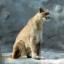

In [55]:
from IPython.display import Image

# Display the image
Image(filename='Dataset/train/cougar_body/image_0001.jpg', width=200, height=200)


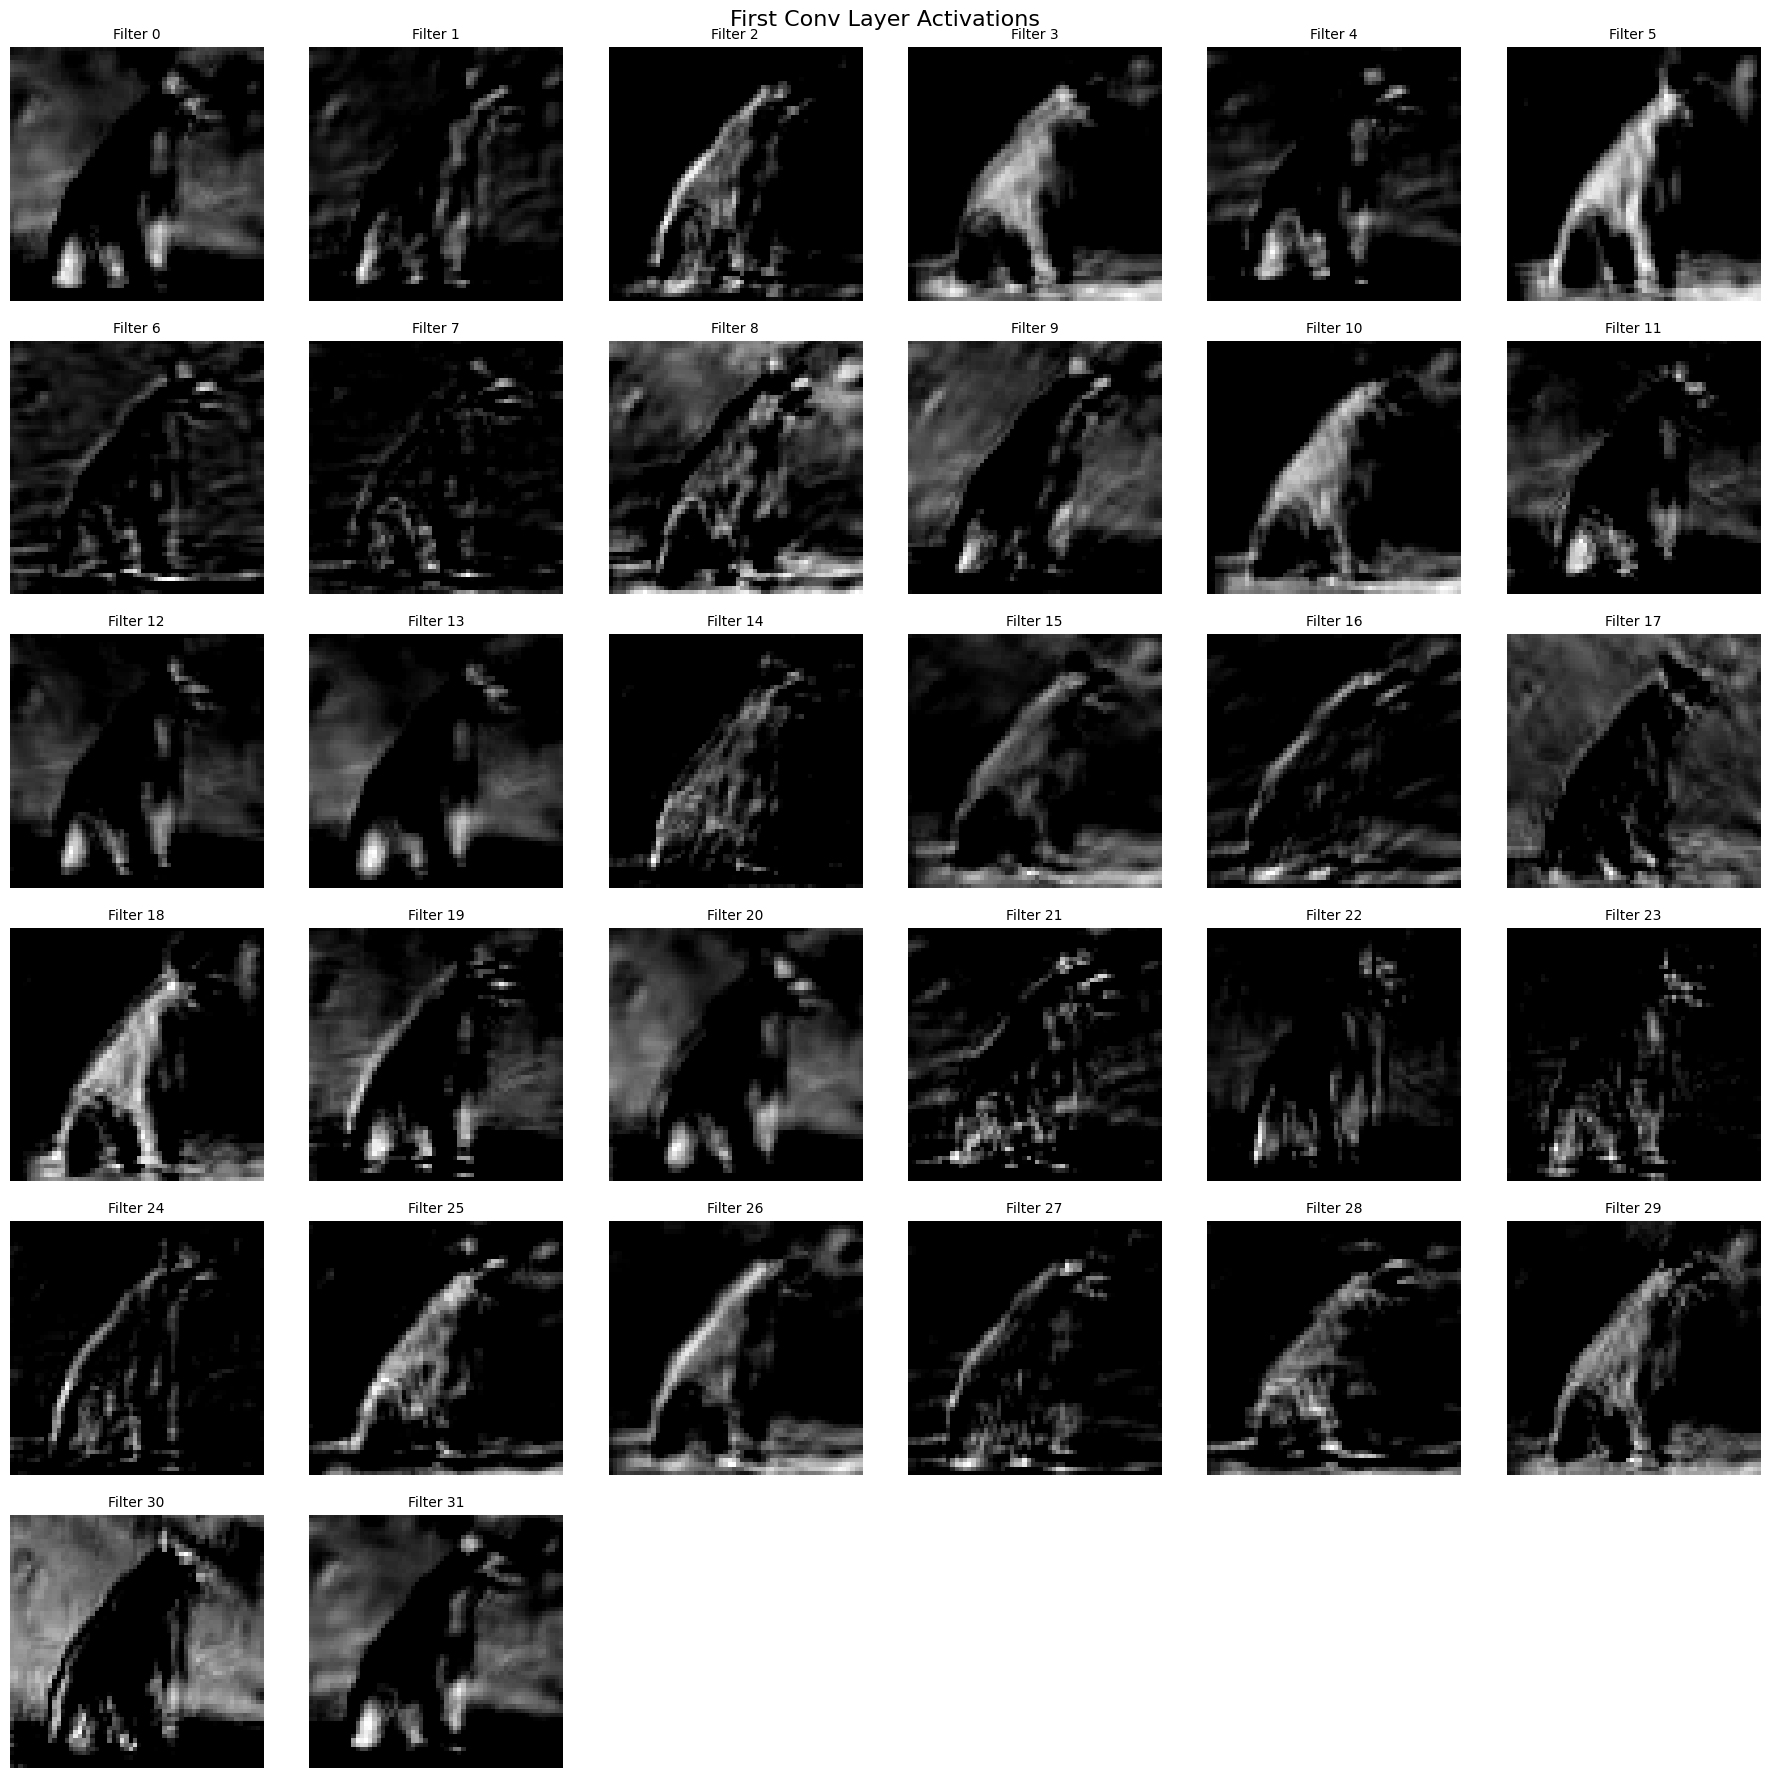

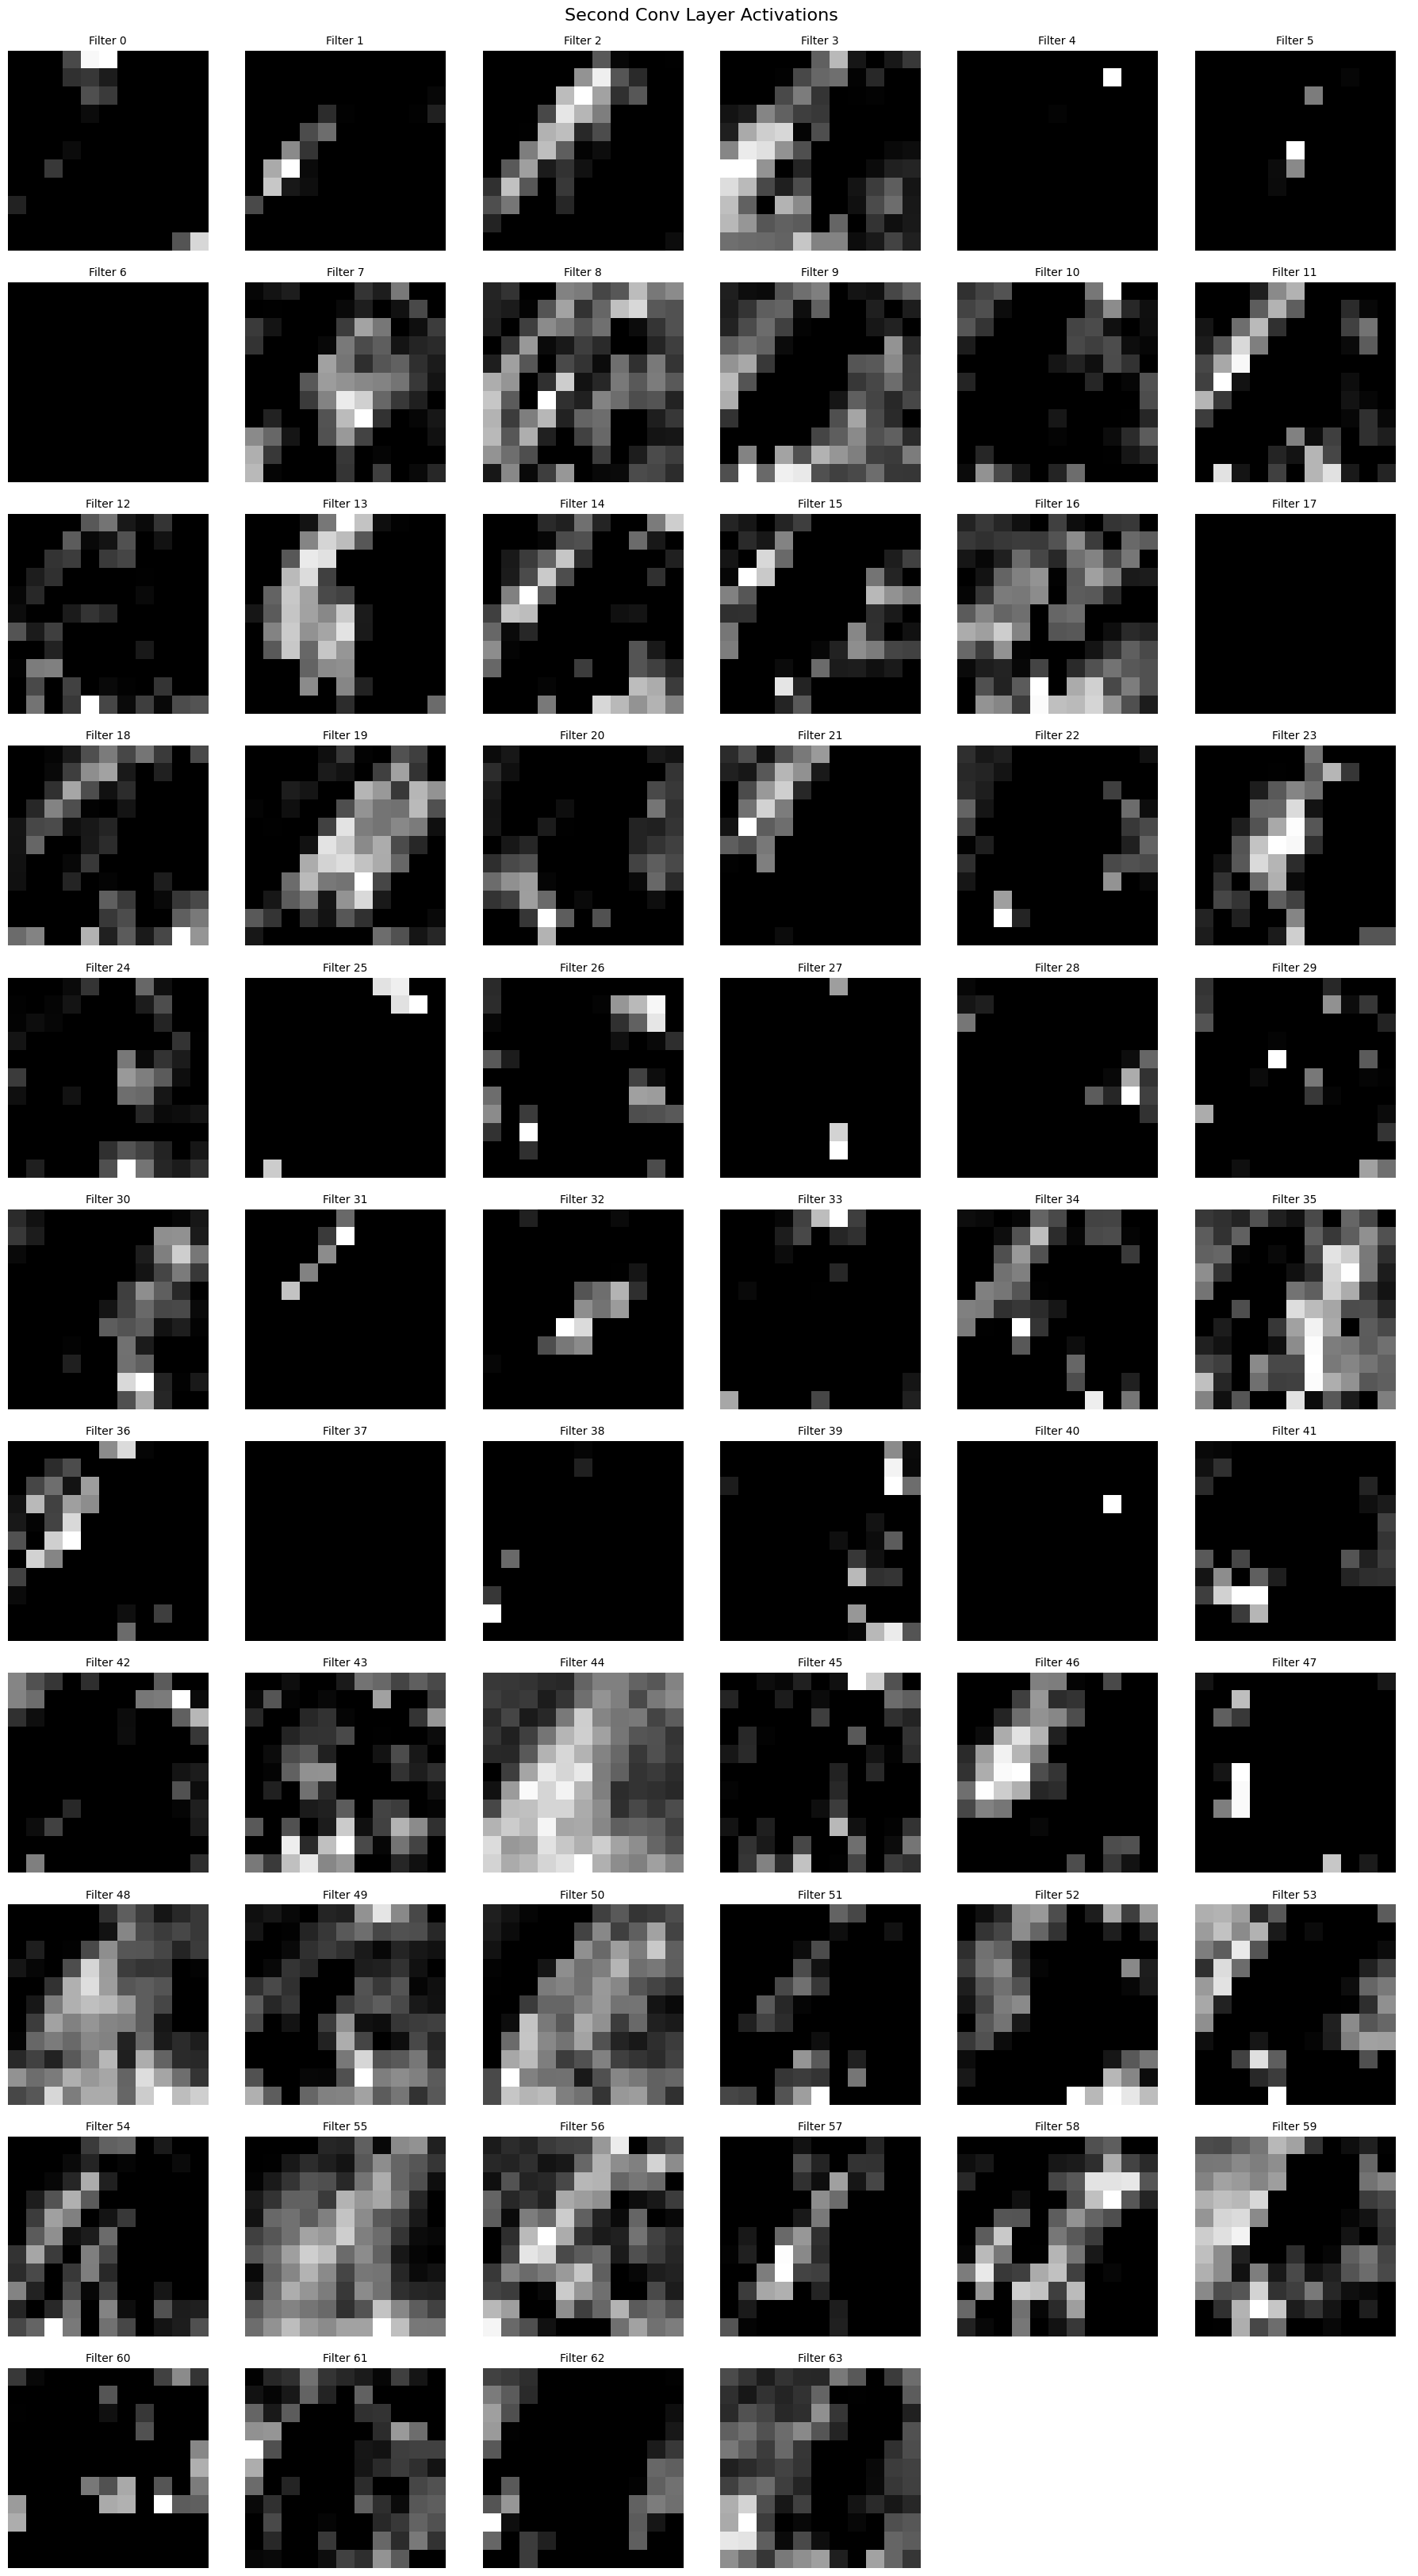

In [51]:
# Forward pass
model.eval()
_ = model(input_accordion)
_ = model(input_camera)

# Visualization function
def visualize_activation_grid_with_titles(activation, title, num_cols=8):
    num_filters = activation.shape[1]
    num_rows = num_filters // num_cols + int(num_filters % num_cols != 0)
    fig_size = num_cols * 3  # Adjust the figure size for larger images
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(fig_size, num_rows * 3))
    axes = axes.flatten()  # Flatten the axes array for easier indexing

    for i in range(num_rows * num_cols):
        if i < num_filters:
            axes[i].imshow(activation[0][i].cpu().numpy(), cmap='gray')
            axes[i].set_title(f"Filter {i}", fontsize=10)  # Title indicating filter index
            axes[i].axis('off')
        else:  # Hide axes for empty subplots
            axes[i].axis('off')

    plt.suptitle(title, fontsize=16)
    plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.5)  # Adjust padding to accommodate titles
    plt.show()



# Visualize activations
# Example usage
visualize_activation_grid_with_titles(activation['conv1'], 'First Conv Layer Activations\n', num_cols=6)
visualize_activation_grid_with_titles(activation['conv2'], 'Second Conv Layer Activations\n \n \n', num_cols=6)



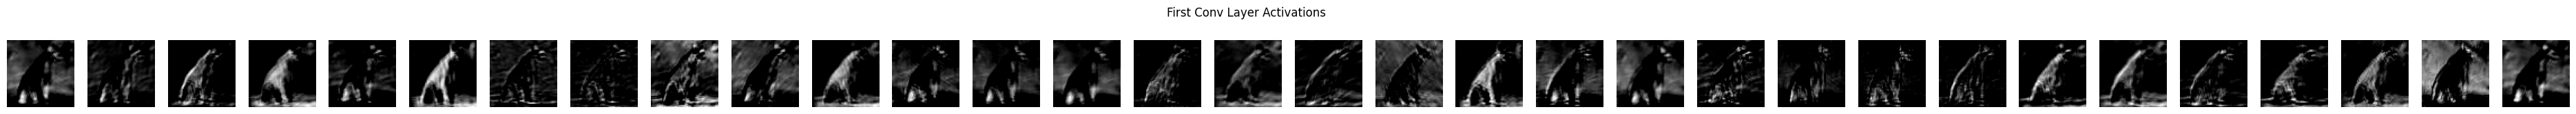

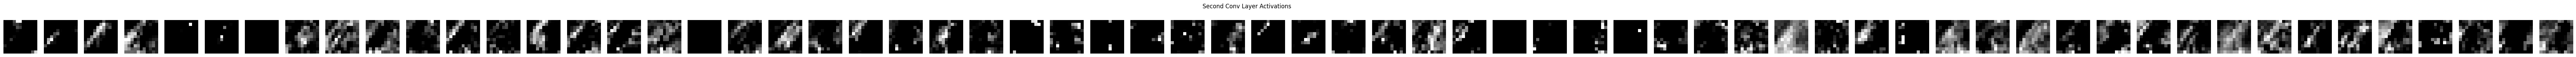

In [52]:
def visualize_activation(activation, title):
    num_filters = activation.shape[1]
    fig, axes = plt.subplots(1, num_filters, figsize=(num_filters * 1.5, 2))
    for i, ax in enumerate(axes):
        ax.imshow(activation[0][i].cpu().numpy(), cmap='gray')
        ax.axis('off')
    plt.suptitle(title)
    plt.show()

# Visualize activations
visualize_activation(activation['conv1'], 'First Conv Layer Activations')
visualize_activation(activation['conv2'], 'Second Conv Layer Activations')

### ResNet Implementation

In [19]:
# implement a ResNet model here
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data.dataset import Subset
from torch.utils.data import DataLoader, random_split
import numpy as np

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != self.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, self.expansion * out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.max_pool2d(out, kernel_size=3, stride=2, padding=1)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

def ResNet18(num_classes=10):
    return ResNet(BasicBlock, [2, 2, 2, 2], num_classes)


In [35]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Adjustments for the ResNet model initialization
def ResNet18(num_classes=10):
    model = ResNet(BasicBlock, [2, 2, 2, 2], num_classes)
    return model

model = ResNet18(num_classes=train_dataset.get_num_classes()).to(device)


transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_dataset = ImageDataset_t(is_val=False,transform = transform)
val_dataset = ImageDataset_t(is_val=True,transform = transform)

train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True, num_workers=0)
val_loader = DataLoader(dataset=val_dataset, batch_size=64, shuffle=False, num_workers=0)

# Loss, optimizer, and scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

# Training loop
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, Accuracy: {100*correct/total:.2f}%')
    scheduler.step()

# Validation loop
model.eval()
total, correct = 0, 0
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f'Validation Accuracy: {100*correct/total:.2f}%')


Epoch [1/10], Loss: 3.2640, Accuracy: 30.40%
Epoch [2/10], Loss: 2.3670, Accuracy: 45.75%
Epoch [3/10], Loss: 1.8101, Accuracy: 55.79%
Epoch [4/10], Loss: 1.4010, Accuracy: 64.63%
Epoch [5/10], Loss: 1.0600, Accuracy: 72.61%
Epoch [6/10], Loss: 0.7686, Accuracy: 79.82%
Epoch [7/10], Loss: 0.5244, Accuracy: 86.39%
Epoch [8/10], Loss: 0.3087, Accuracy: 92.17%
Epoch [9/10], Loss: 0.1352, Accuracy: 97.49%
Epoch [10/10], Loss: 0.0527, Accuracy: 99.34%
Validation Accuracy: 73.11%


# 73.11 % validation accuracy on ResNet_18

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


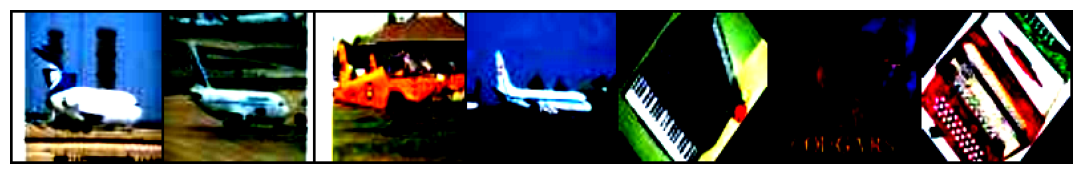

Image 1: Predicted: "airplanes", Expected: "airplanes"
Image 2: Predicted: "airplanes", Expected: "airplanes"
Image 3: Predicted: "airplanes", Expected: "airplanes"
Image 4: Predicted: "airplanes", Expected: "airplanes"
Image 5: Predicted: "accordion", Expected: "accordion"
Image 6: Predicted: "Leopards", Expected: "cougar_body"
Image 7: Predicted: "accordion", Expected: "accordion"


In [48]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision

# Function to display a row of images with their predictions and truths
def show_images_predictions(images, labels, predicted, num_images=7):
    # Select a random subset of images
    indices = np.random.choice(range(len(images)), num_images, replace=False)
    selected_images = images[indices]
    selected_labels = labels[indices]
    selected_predictions = predicted[indices]


    resized_images = torch.nn.functional.interpolate(selected_images, scale_factor=0.5)

    # Display images in a row
    img_grid = torchvision.utils.make_grid(resized_images, nrow=num_images)
    npimg = img_grid.numpy()
    plt.figure(figsize=(17, 2))  # Adjust figure size to accommodate the row of images
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()

    # Print predicted and expected labels for each selected image
    for i in range(num_images):
        print(f'Image {i+1}: Predicted: "{get_class_name(selected_predictions[i].item())}", Expected: "{get_class_name(selected_labels[i].item())}"')

# Fetch a single batch from the validation loader
dataiter = iter(val_loader)
images, labels = next(dataiter)

# Transfer to device, compute outputs
images, labels = images.to(device), labels.to(device)
outputs = model(images)

# Get the index of the highest score for each image
_, predicted = torch.max(outputs, 1)

# Display images and their labels
show_images_predictions(images.cpu(), labels.cpu(), predicted.cpu(), num_images=7)  # Adjust num_images as needed


In [49]:
torch.save(ResNet18, 'ResNet18-73%validation_accuracy.pth')